In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import sys
sys.path.append('../')

import pyro
from src.models.bnn import BNN, NN
from src.models.nets.network import NetAtom
import torch
import pytorch_lightning as L
import torch.utils.data as data
import numpy as np
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from optuna import Study
import optuna
from optuna.trial import Trial

from src.datamodule.aenet_datamodule import AenetDataModule

/home/g15farris/.conda/envs/bayesian/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
datamodele = AenetDataModule(
    data_dir='../data/PdO/train.in',
    batch_size=100,
    test_split=0.1,
    valid_split=0.1
    )

0.1


0.8 0.1 0.1
[12833, 10600, 4868, 5601, 6351]
0.8 0.1 0.1
[297, 7446, 3021, 11251, 9173]


In [9]:
datamodele.hidden_size

[[15, 10], [15, 10]]

In [5]:
net = NetAtom(
    datamodele.input_size, 
    datamodele.hidden_size, 
    datamodele.species, 
    datamodele.active_names, 
    datamodele.alpha,
    'cpu'
)

In [6]:
model_kwargs = {'net': net,
        'lr': 0.00025616626859234823,
        'pretrain_epochs': 5,
        'mc_samples_train': 1,
        'mc_samples_eval': 20, 
        'dataset_size': datamodele.train_size, 
        'fit_context': 'lrt', 
        'prior_loc': 0, 
        'prior_scale': 0.3726682199695302, 
        'guide': 'normal', 
        'q_scale': 0.00127000766093029489207278289472795143,
        'obs_scale' :  0.8115512648735741}

In [7]:
Params = {'lr': 0.0009557919854270005, 
  'mc_samples_train': 2 ,
  'obs_scale': 0.9923450035121233,
  'pretrain_epochs': 5 ,
  'prior_scale': 0.013211454149960021,
  'q_scale': 0.0008078440753477169,}

model_kwargs.update(Params)

In [8]:
early_stopping = EarlyStopping(monitor='elbo/val', min_delta = 0., # minimum change in the monitored quantity to qualify as an improvement
  patience= 3, # number of checks with no improvement after which training will be stopped
  verbose= False, # verbosity mode
  mode= "min", # "max" means higher metric value is better, can be also "min"
  strict= True, # whether to crash the training if monitor is not found in the validation metrics
  check_finite= True,) # when set True, stops training when the monitor becomes NaN or infinite
#   'stopping_threshold'= null, # stop training immediately once the monitored quantity reaches this threshold
#   'divergence_threshold'= null, # stop training as soon as the monitored quantity becomes worse than this threshold
#   'check_on_train_epoch_end'= null,)

early_stopping = EarlyStopping(
    monitor='elbo/val',
    patience=100,
    mode='min' )

In [9]:
model = BNN(**model_kwargs)
trainer = L.Trainer(max_epochs = 2000)
trainer.fit(model=model, datamodule=datamodele)#, ckpt_path=trainer.checkpoint_callback.best_model_path)
             #ckpt_path='/home/riccardo/bin/repos/aenet-bnn/src/logs/train_lrt/runs/2024-04-23_12-42-33/checkpoints/epoch_347-step_22460.ckpt')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/g15farris/.conda/envs/bayesian/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:181: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type    | Params
---------------------------------
0 | net  | NetAtom | 1.9 K 
---------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/123 [00:00<?, ?it/s]                           

/home/g15farris/.conda/envs/bayesian/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 0: 100%|██████████| 123/123 [00:13<00:00,  8.85it/s, v_num=44]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 123/123 [00:13<00:00,  8.86it/s, v_num=44]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  93%|█████████▎| 14/15 [00:02<00:00,  6.78it/s]

: 

In [105]:
trainer.test(model=model, datamodule=datamodele, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at /home/riccardo/bin/repos/aenet-bnn/notebooks/lightning_logs/version_13/checkpoints/epoch=24-step=5400.ckpt
Loaded model weights from the checkpoint at /home/riccardo/bin/repos/aenet-bnn/notebooks/lightning_logs/version_13/checkpoints/epoch=24-step=5400.ckpt


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 17.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         mse/test          │   0.039903706295831926    │
│         nll/test          │    0.11132489726659382    │
└───────────────────────────┴───────────────────────────┘

[{'nll/test': 0.11132489726659382, 'mse/test': 0.039903706295831926}]

In [110]:
valid = datamodele.grouped_train_data
x = valid[0][10], valid[0][12]
y_true = valid[0][11]
y_pred, y_std = model.bnn.predict(x[0], x[1], num_predictions=20)

y_pred = y_pred.numpy()
y_std = y_std.numpy() #- model_kwargs['obs_scale']
y_true = y_true.numpy()

In [118]:
len(datamodele.grouped_train_data[11][11])

64

R2 score: 0.930


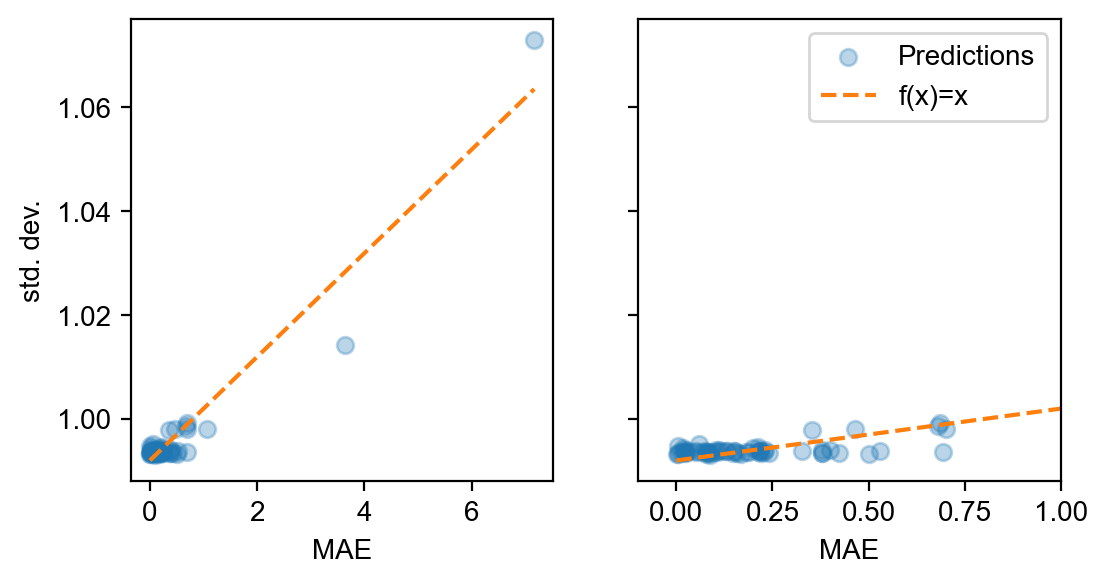

In [111]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rcParams.update({
    "figure.dpi" : 200,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "font.size" : 10,
    'mathtext.default': 'regular'
})

regr = LinearRegression()

x_model = abs(y_pred-y_true).reshape(-1,1)
y_model = y_std.reshape(-1,1)

regr.fit(x_model, y_model)
y_model_pred = regr.predict(x_model)
x_modelito = np.linspace(0, max(x_model), 100).reshape(-1,1)


fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=True)

ax[0].scatter(x_model, y_model, alpha=0.3)
ax[0].plot(x_modelito, regr.predict(x_modelito), '--', color='tab:orange', label='f(x)=x')


print('R2 score: {:.3f}'.format(r2_score(y_model, y_model_pred)))
ax[1].scatter(x_model, y_model, alpha=0.3, label='Predictions')

ax[1].plot(x_modelito, regr.predict(x_modelito), '--', color='tab:orange', label='f(x)=x')

ax[1].set_xlim(-0.1,1)
#ax[0].text(0.1,1.7, 'R2 score: {:.3f}'.format(r2_score(y_model, y_model_pred)))
ax[1].set_xlabel('MAE')
ax[0].set_xlabel('MAE')
ax[0].set_ylabel('std. dev.')
ax[1].legend()
#plt.xlim(0,0.5)

<Axes: title={'center': 'Residuals vs. Predictive Standard Deviations'}, xlabel='Standard Deviations (Scaled)', ylabel='Residuals (Absolute Value)'>

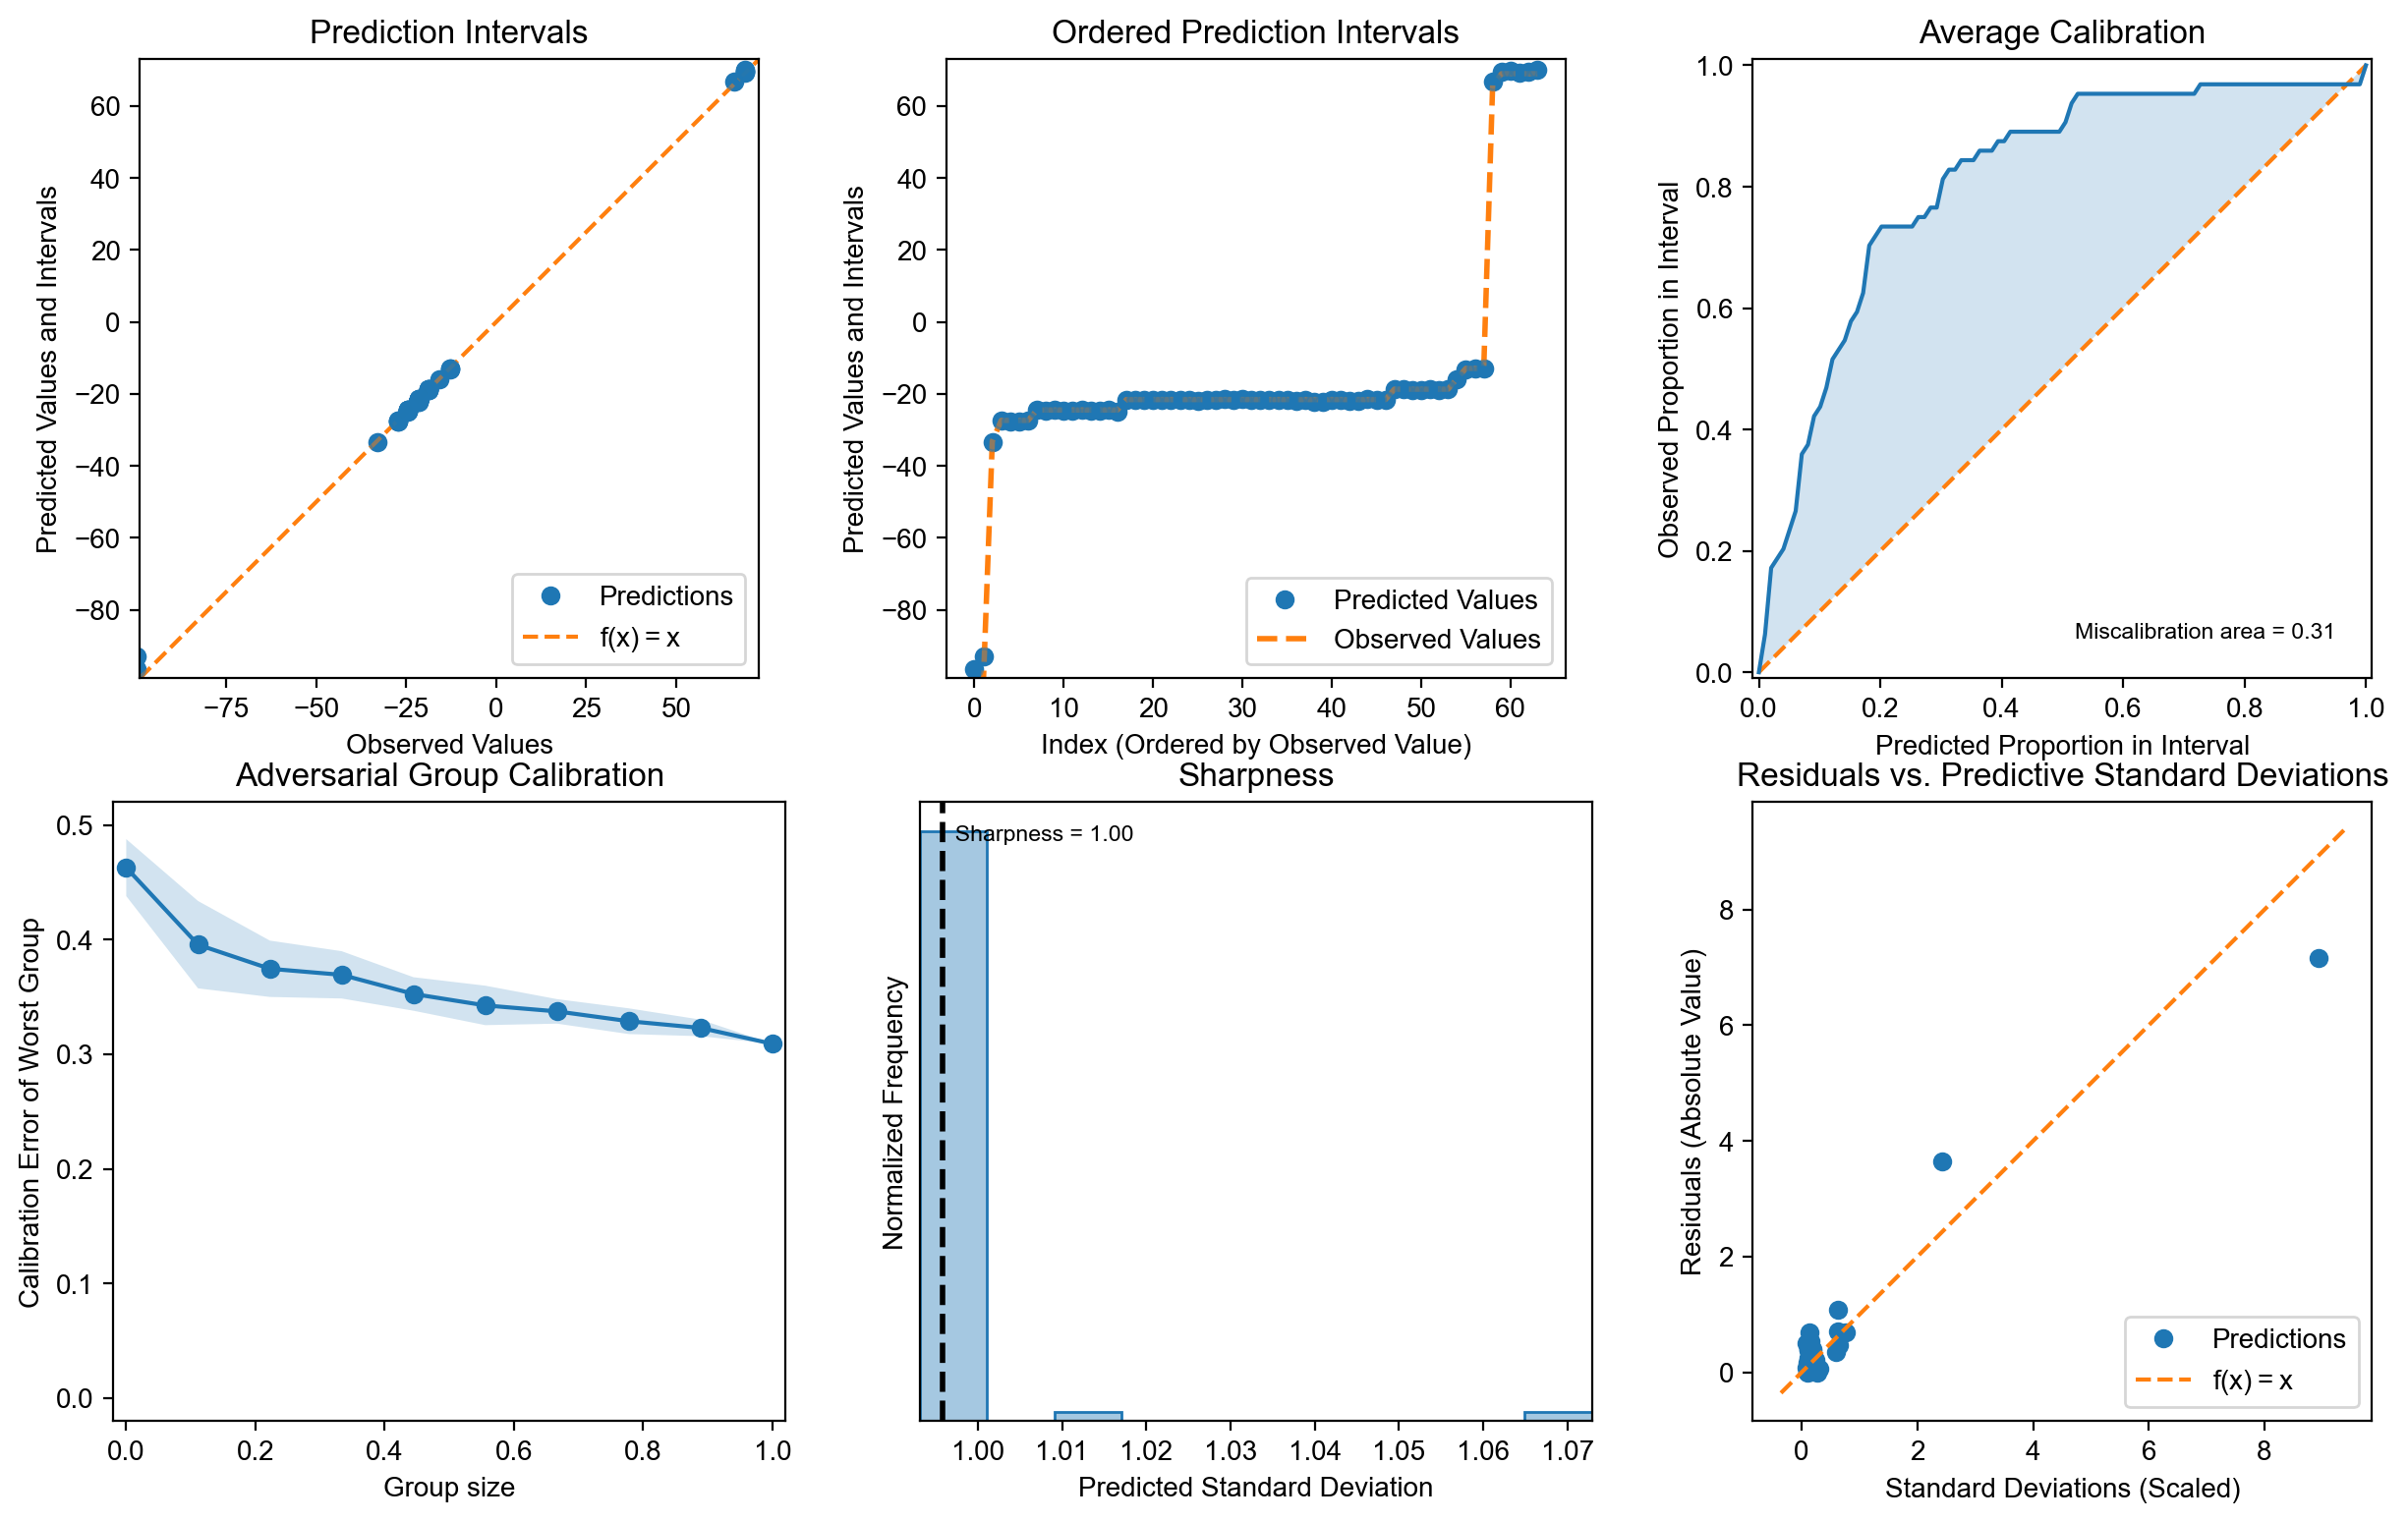

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct

plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(2, 3, figsize=(15, 9))
ax = ax.flat
uct.plot_intervals(y_pred, y_std, y_true, ax=ax[0])
uct.plot_intervals_ordered(y_pred, y_std, y_true, ax=ax[1])
uct.plot_calibration(y_pred, y_std, y_true, ax=ax[2])
uct.plot_adversarial_group_calibration(y_pred, y_std, y_true, ax=ax[3])
uct.plot_sharpness(y_std, ax=ax[4])
uct.plot_residuals_vs_stds(y_pred, y_std- model_kwargs['obs_scale'], y_true, ax=ax[5])

In [4]:
import numpy as np

a = np.array([1])
b = np.array([1])

a = np.concatenate((a, b))
a = np.concatenate((a, b))
a

array([1, 1, 1])